# **Image Captioning**

The process of generating descriptions of the image using pretrained models.

We have opted to use the Encoder - Decoder architecture using CNN and RNN respectively.

Steps include:


*   Data Setup
*   Preprocessing - Tokenization
*   Image feature extraction - Converts images into feature vectors
*   Data Generator - Converts data into smaller batches for efficient processing
*   Build Model with CNN to process feature vector and LSTM to process captions
*   Training
*   **Testing**







## Setup

**Import Data from Kaggle**

In [62]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("adityajn105/flickr8k")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/adityajn105/flickr8k/versions/1


**Import initial libraries**

In [63]:
import numpy as np
import pandas as pd
import os
import warnings
import matplotlib.pyplot as plt

plt.rcParams['font.size'] = 12
warnings.filterwarnings('ignore')

**Display captions**

In [64]:
data = pd.read_csv(path + "/captions.txt")
data.head()

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


**Display Images**

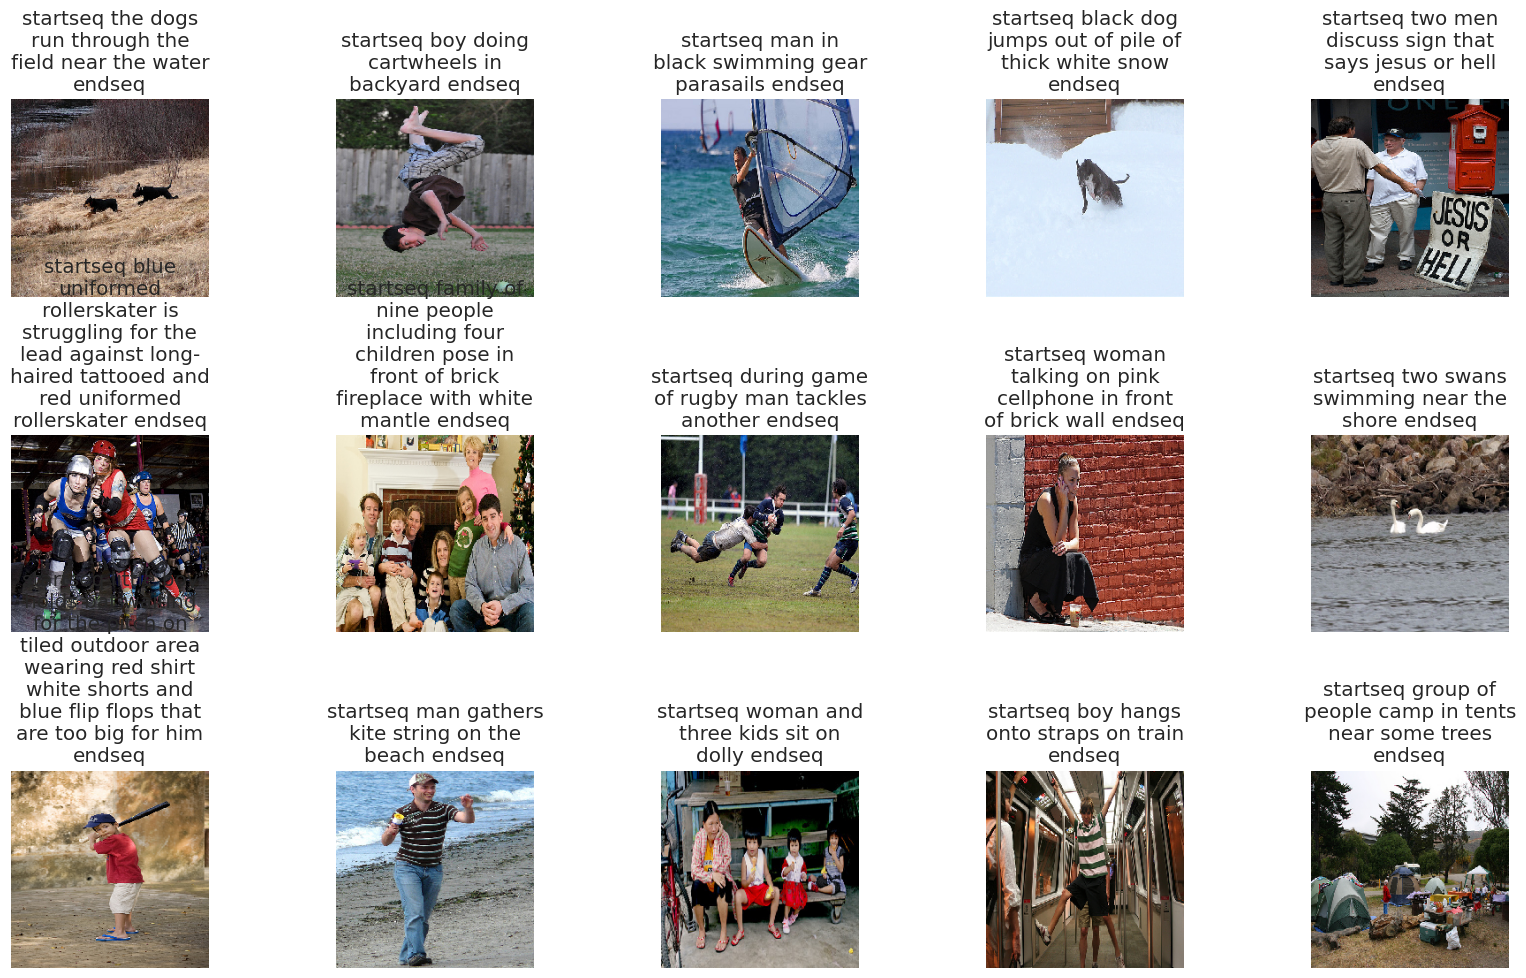

In [69]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from textwrap import wrap

image_path = path + "/Images"

def visualizeImages(data):
    data = data.reset_index(drop=True)
    plt.figure(figsize = (20 , 20))
    n = 0
    for i in range(15):
        n+=1
        plt.subplot(5 , 5, n)
        plt.subplots_adjust(hspace = 0.7, wspace = 0.3)
        image = load_img(image_path+ f"/{data.image[i]}",color_mode='rgb',target_size=(224, 224))
        image = img_to_array(image)
        image = image/255.
        plt.imshow(image)
        plt.title("\n".join(wrap(data.caption[i], 20)))
        plt.axis("off")

visualizeImages(data.sample(15))

## Data Preprocessing
**Caption Preprocessing**



In [71]:
data['caption'] = data['caption'].apply(lambda x: x.lower())
data['caption'] = data['caption'].apply(lambda x: x.replace("[^A-Za-z]",""))
data['caption'] = data['caption'].apply(lambda x: x.replace("\s+"," "))
data['caption'] = data['caption'].apply(lambda x: " ".join([word for word in x.split() if len(word)>1]))
data['caption'] = "startseq "+data['caption']+" endseq"
captions = data['caption'].tolist()
captions[:10]

['startseq startseq startseq child in pink dress is climbing up set of stairs in an entry way endseq endseq endseq',
 'startseq startseq startseq girl going into wooden building endseq endseq endseq',
 'startseq startseq startseq little girl climbing into wooden playhouse endseq endseq endseq',
 'startseq startseq startseq little girl climbing the stairs to her playhouse endseq endseq endseq',
 'startseq startseq startseq little girl in pink dress going into wooden cabin endseq endseq endseq',
 'startseq startseq startseq black dog and spotted dog are fighting endseq endseq endseq',
 'startseq startseq startseq black dog and tri-colored dog playing with each other on the road endseq endseq endseq',
 'startseq startseq startseq black dog and white dog with brown spots are staring at each other in the street endseq endseq endseq',
 'startseq startseq startseq two dogs of different breeds looking at each other on the road endseq endseq endseq',
 'startseq startseq startseq two dogs on pav

**Tokenization**

In [72]:
from tensorflow.keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(captions)
vocab_size = len(tokenizer.word_index) + 1
max_length = max(len(caption.split()) for caption in captions)

images = data['image'].unique().tolist()
nimages = len(images)

split_index = round(0.85*nimages)
train_images = images[:split_index]
val_images = images[split_index:]

train = data[data['image'].isin(train_images)]
test = data[data['image'].isin(val_images)]

train.reset_index(inplace=True,drop=True)
test.reset_index(inplace=True,drop=True)

tokenizer.texts_to_sequences([captions[1]])[0]

[1, 1, 1, 18, 315, 63, 195, 116, 2, 2, 2]